In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


2025-09-28 07:10:19.629759: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-28 07:10:20.461748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-28 07:10:23.700871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [14]:
tf.config.optimizer.set_jit(False)


In [2]:
# Step 1: Load Dataset
# -----------------------------------------------------
train_ds, test_ds = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"],
    as_supervised=True   # returns (image, label)
)

I0000 00:00:1759043440.695396    1888 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# Step 2: Preprocessing Function
# -----------------------------------------------------
NUM_CLASSES = 5
IMG_SIZE = (150, 150)

In [4]:
def preprocess(image, label):
    # Resize
    image = tf.image.resize(image, IMG_SIZE)
    # Preprocess for VGG16
    image = preprocess_input(image)
    # One-hot encode labels
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

In [5]:
# Apply preprocessing + batching
train_ds = (train_ds
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(1000)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE))

In [6]:
test_ds = (test_ds
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(32)
           .prefetch(tf.data.AUTOTUNE))

In [7]:
# Step 3: Load Pre-trained Model (VGG16)
# -----------------------------------------------------
base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_shape=(150, 150, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [8]:
base_model.trainable = False  # freeze convolutional base

In [9]:
# Custom classifier
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
# Step 4: Compile & Train
# -----------------------------------------------------
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy',
                   mode='max',
                   patience=5,
                   restore_best_weights=True)

In [11]:
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    callbacks=[es]
)

Epoch 1/5


2025-09-28 07:13:02.979465: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-09-28 07:13:03.475417: I external/local_xla/xla/service/service.cc:163] XLA service 0x7701340158c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-28 07:13:03.475454: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-09-28 07:13:03.535813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-28 07:13:02.774643: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
2025-09-28 07:13:02.836379: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficien

79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4804 - loss: 2.4409

2025-09-28 07:13:38.460549: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-28 07:13:39.274366: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-28 07:13:40.798586: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-28 07:13:41.880650: W external/local_xla/xla/ts

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.4829 - loss: 2.4160

2025-09-28 07:13:56.942790: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


81/81 ━━━━━━━━━━━━━━━━━━━━ 59s 528ms/step - accuracy: 0.5792 - loss: 1.4299 - val_accuracy: 0.7312 - val_loss: 0.8290
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.7723 - loss: 0.7368 - val_accuracy: 0.8338 - val_loss: 0.5596
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 293ms/step - accuracy: 0.8571 - loss: 0.4757 - val_accuracy: 0.8847 - val_loss: 0.3427
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 299ms/step - accuracy: 0.8953 - loss: 0.3347 - val_accuracy: 0.9010 - val_loss: 0.2637
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 308ms/step - accuracy: 0.9268 - loss: 0.2440 - val_accuracy: 0.9391 - val_loss: 0.1915


In [12]:
# -----------------------------------------------------
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss, "Accuracy:", accuracy)

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.9391 - loss: 0.1915
Loss: 0.19150647521018982 Accuracy: 0.9391462206840515


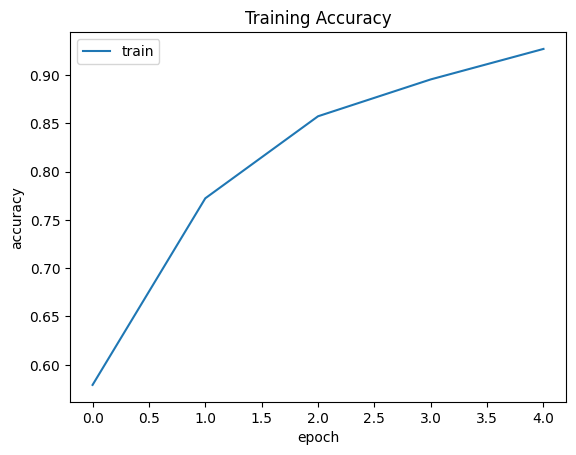

In [13]:
# Step 6: Plot Accuracy
# -----------------------------------------------------
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [15]:
%autosave


UsageError: %autosave requires an integer, got ''


In [16]:
%autosave 30


Autosaving every 30 seconds
